In [1]:
!pip install keras

In [2]:
import pandas as pd
import numpy as np

from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

import random

import keras

%matplotlib inline

Using TensorFlow backend.


In [3]:
mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

imapping = {
    'Angry': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happy': 3,
    'Sad': 4,
    'Surprise': 5,
    'Neutral': 6
}


def flip_horizontally(image):
    return np.flip(image, axis=1)


def add_noise(image):
    return image + np.random.poisson(image.astype('float64'))


def rotate_right(image, angle=-20):
    return rotate(image, angle, mode='reflect', reshape=False)


def rotate_left(image, angle=20):
    return rotate(image, angle, mode='reflect', reshape=False)


def add_blur(image):
    return gaussian_filter(image, sigma=1)

In [4]:
def find_subsets(df: pd.DataFrame, class_to_fraction: dict):
    """
    select random subsets for given classes with given fractions
    :param df: data
    :param class_to_fraction: dictionary {'emotion' : fraction of the data to that is going to be augmented}
    :return: indices of the images to augmented
    """
    data = df.loc[df['y'].isin(class_to_fraction.keys())]
    indices = []
    for emotion in class_to_fraction.keys():
        temp = data.loc[data['y'] == emotion]
        indices = indices + random.sample(temp.index.tolist(), int(class_to_fraction[emotion] * len(temp)))

    return indices

In [5]:
class Augmenter:

    @staticmethod
    def augment_images(df: pd.DataFrame, 
                       target_file: str = None, 
                       class_to_fraction: dict = {'Disgust': 1}, 
                       augmentations: list = ['flip']) -> pd.DataFrame:

        # df = pd.read_csv(source_file)

        df['category'] = df['category'].str.strip()

        del df['Unnamed: 0']

        df['y'] = df['y'].map(mapping)

        indices = find_subsets(df, class_to_fraction)

        print(len(indices))
        temp = []

        if 'flip' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + flip_horizontally(
                    np.array(df.iloc[index, 1:2305]).reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'noise' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + add_noise(
                    np.array(df.iloc[index, 1:2305]).reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'rotate_right' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + rotate_right(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'rotate_left' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + rotate_left(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'blur' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + add_blur(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        print(len(temp))

        data = pd.DataFrame(temp, columns=df.columns)

        if target_file:
            data.to_csv(target_file)

        return data

### Read data

In [6]:
df = pd.read_csv('emotions.csv')

In [7]:
df['category'] = df['category'].str.strip()

In [8]:
train = df[df['category'] == 'Training']
valid = df.loc[df.category == 'PublicTest']
test  = df.loc[df.category == 'PrivateTest']

#### Create a dictionary with classes fractions to augment

In [9]:
ctf = {
    'Disgust': 1,
    'Sad': 0.1,
    'Fear': 0.1,
    'Neutral': 0.1,
    'Angry': 0.1
}

In [10]:
aug = Augmenter.augment_images(train.copy(), None, ctf, ['flip', 'rotate_right', 'rotate_left', 'blur', 'noise'])

2223
11115


In [11]:
train.head()

,Unnamed: 0,y,0,1,2,3,4,5,6,7,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,0,0,70,80,82,72,58,58,60,63,...,182,183,136,106,116,95,106,109,82,Training
1,1,0,151,150,147,155,148,133,111,140,...,108,95,108,102,67,171,193,183,184,Training
2,2,2,231,212,156,164,174,138,161,173,...,138,152,122,114,101,97,88,110,152,Training
3,3,4,24,32,36,30,32,23,19,20,...,126,132,132,133,136,139,142,143,142,Training
4,4,6,4,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,Training


In [12]:
aug.head()

,y,0,1,2,3,4,5,6,7,8,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,Fear,116,119,123,128,131,135,140,144,144,...,199,207,214,216,238,254,251,241,195,Training
1,Fear,247,249,249,249,252,70,36,22,14,...,167,167,150,144,147,156,155,164,127,Training
2,Fear,52,53,53,53,51,50,51,64,68,...,100,99,125,123,124,119,103,103,115,Training
3,Fear,115,123,91,42,25,36,47,44,29,...,60,46,46,52,71,96,113,64,0,Training
4,Fear,248,240,248,255,254,253,253,253,253,...,219,219,221,222,223,223,224,219,213,Training


In [13]:
del train['Unnamed: 0']
del valid['Unnamed: 0']
del test['Unnamed: 0']

In [14]:
aug['y'] = aug['y'].map(imapping)

In [15]:
train = train.append(aug.sample(frac=1), ignore_index=True)

In [16]:
X_train = np.array(train.iloc[:, 1:2305])
y_train = np.array(train.loc[:, ['y']])

X_val = np.array(valid.iloc[:, 1:2305])
y_val = np.array(valid.loc[:, ['y']])

X_test = np.array(test.iloc[:, 1:2305])
y_test = np.array(test.loc[:, ['y']])

In [17]:
y_train = keras.utils.to_categorical(y_train, 7)
y_val = keras.utils.to_categorical(y_val, 7)
y_test = keras.utils.to_categorical(y_test, 7)

X_train_r = X_train.reshape((len(X_train), 48, 48))
X_val_r   = X_val.reshape((len(X_val), 48, 48))
X_test_r   = X_test.reshape((len(X_test), 48, 48))

In [18]:
del X_train
del X_val
del X_test

del train
del valid
del test

del df

del aug

In [19]:
X_train_r = X_train_r / 255
X_val_r = X_val_r / 255
X_test_r = X_test_r / 255

# X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
# X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
# X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)

In [20]:
X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))

### Model

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from keras.models import model_from_json

from keras.metrics import categorical_accuracy

np.random.seed(100)

In [22]:
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [23]:
model.load_weights('baseline.h5')

In [25]:
history = model.fit(X_train_bw, y_train, batch_size=128, epochs=10, validation_data=(X_val_bw, y_val))

Train on 39824 samples, validate on 3589 samples
Epoch 1/10
39824/39824 [==============================] - 59s 1ms/step - loss: 0.4985 - categorical_accuracy: 0.8626 - val_loss: 1.3138 - val_categorical_accuracy: 0.6456
Epoch 2/10
39824/39824 [==============================] - 44s 1ms/step - loss: 0.3448 - categorical_accuracy: 0.8890 - val_loss: 1.4790 - val_categorical_accuracy: 0.6339
Epoch 3/10
39824/39824 [==============================] - 44s 1ms/step - loss: 0.2861 - categorical_accuracy: 0.9060 - val_loss: 1.5772 - val_categorical_accuracy: 0.6188
Epoch 4/10
39824/39824 [==============================] - 44s 1ms/step - loss: 0.2462 - categorical_accuracy: 0.9147 - val_loss: 1.5938 - val_categorical_accuracy: 0.6383
Epoch 5/10
39824/39824 [==============================] - 44s 1ms/step - loss: 0.2199 - categorical_accuracy: 0.9235 - val_loss: 1.6555 - val_categorical_accuracy: 0.6305
Epoch 6/10
39824/39824 [==============================] - 44s 1ms/step - loss: 0.1971 - categori

In [26]:
model.evaluate(X_test_bw, y_test)

3589/3589 [==============================] - 2s 488us/step


[1.674819767076546, 0.6492059069544733]

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [31]:
y['pred'] = model.predict_classes(X_test_bw)
y['true'] = y['true'].map(mapping)
y['pred'] = y['pred'].map(mapping)

In [32]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


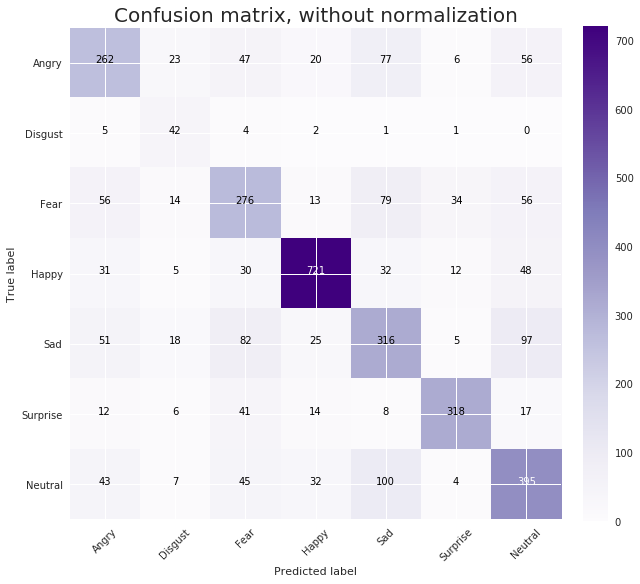

In [33]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


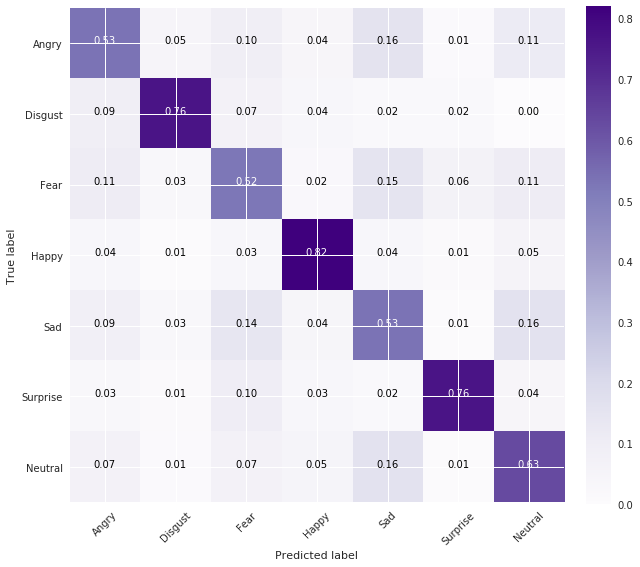

In [35]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')